In [1]:
# Load necessary modules and dataset 
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyber-gpu/lib/python3.10/site-packages")

import matplotlib.pyplot as plt
from functions import *
from utils import *

In [28]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_2_0_10.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)


In [29]:
num_observations = 100
num_monomers = 100

# Sample the dataset according to num_observation
# Generate random indices that will randomly pickl num_observations from the list
indices = np.random.choice(len(dataset_list[0]['observation_list']), num_observations, replace=False)

template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list'][indices]
label_list = dataset_list[0]['labels'][indices]

observation_flatten_list = [squareform(pdist(x[:num_monomers, :])).flatten() for x in X]

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x[:num_monomers, :])).flatten() for x in template_list]

# Generate random walk for guessing structures
# num_monomers = param_dict['num_monomers']
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
# num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

In [10]:
lpm = [(logprior(x, num_monomers)).tolist() for x in templates_flatten]

In [11]:
observations_flatten = [squareform(pdist(x)).flatten().tolist() for x in X]

In [12]:
N = num_observations 
M = num_candidates
N_probe = num_probes
noise_std = measurement_error
dmap = observations_flatten
lpm_vec = lpm

In [13]:
N

100

In [2]:
## import necessary modules
import os, sys
import csv
from tqdm import tqdm
import numpy as np
import torch
# from scipy.special import logsumexp
import json

In [15]:
from cmdstanpy import CmdStanModel

In [16]:
my_model = CmdStanModel(
    stan_file='/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/stan/20240715_WeightStructureOptimization.stan',
    cpp_options = {
        "STAN_THREADS": True,
    }
)

In [17]:
import multiprocessing
n_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {n_cores}")
parallel_chains = 4
threads_per_chain = int(n_cores / parallel_chains)
print(f"Number of threads per chain: {threads_per_chain}")

Number of CPU cores: 64
Number of threads per chain: 16


In [3]:
output_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/test/20240716_StructureWeight'
os.makedirs(output_dir, exist_ok=True)

In [19]:
# Write json files for reading into stan program
json_filename = os.path.join(output_dir, 'data.json')
stan_output_file = os.path.join(output_dir, 'stan_output')
data_dict = {
    "M": M,
    "N": N,
    "N_probe": N_probe,
    "noise_std": noise_std,
    "dmap": dmap,
    "lpm_vec": lpm_vec,
}

json_obj = json.dumps(data_dict, indent=4)

with open(json_filename, 'w') as json_file:
    json_file.write(json_obj)
    json_file.close()

In [20]:
# Run Stan model to perform MCMC sampling
data_file = json_filename

In [21]:
fit = my_model.sample(
    data=data_file,
    chains=4,
    sig_figs=8,
    parallel_chains=parallel_chains,
    threads_per_chain=threads_per_chain,
    iter_warmup=1000,
    iter_sampling=1000,
    show_console=True,
)

13:26:32 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/test/20240716_StructureWeight/data.json
init = 2 (Default)
random
seed = 92895
output
file = /tmp/tmpa35miaat/20240715_WeightStructureOptimizationspatou61/20240715_WeightStructureOptimization-20240716132632.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = 8
profile_file = profile.csv

21:43:48 - cmdstanpy - INFO - CmdStan done processing



Elapsed Time: 14184.5 seconds (Warm-up)
15650.8 seconds (Sampling)
29835.3 seconds (Total)







21:43:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1000 iterations at max treedepth (100.0%)
	Chain 2 had 1000 iterations at max treedepth (100.0%)
	Chain 3 had 1000 iterations at max treedepth (100.0%)
	Chain 4 had 1000 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [22]:
# Save Stan output, i.e., posterior samples, in CSV format, in a specified folder

fit.save_csvfiles(dir=stan_output_file)

In [4]:
stan_output_file = os.path.join(output_dir, 'stan_output')
stan_directory = stan_output_file

In [5]:
log_weights = []
lp = []
files = sorted(os.listdir(stan_directory))[-4:]
print(files)

['20240715_WeightStructureOptimization-20240716132632_1.csv', '20240715_WeightStructureOptimization-20240716132632_2.csv', '20240715_WeightStructureOptimization-20240716132632_3.csv', '20240715_WeightStructureOptimization-20240716132632_4.csv']


In [18]:
N_metastructure = 2 
N_monomers = 100

In [35]:
log_weights_d = []
metastructure_d_1 = []
metastructure_d_2 = []
for file in files:
    log_weights_chain = []
    metastructure_chain_1 = []
    metastructure_chain_2 = []
    lp_chain = []
    with open('%s/%s'%(stan_directory, file), newline='') as csvfile:
        reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
        for row in reader:
            data_dict = row
            log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,N_metastructure+1)]
            lp_chain.append(float(row["lp__"]))
            metastructure_row_1 = [float(row["mu.1.{}".format(j)]) for j in range(1,(N_monomers)**2+1)]
            metastructure_row_2 = [float(row["mu.2.{}".format(j)]) for j in range(1,(N_monomers)**2+1)]
            log_weights_chain.append(log_weights_row)
            metastructure_chain_1.append(metastructure_row_1)
            metastructure_chain_2.append(metastructure_row_2)
    log_weights_d.append(log_weights_chain)
    metastructure_d_1.append(metastructure_chain_1)
    metastructure_d_2.append(metastructure_chain_2)
    

In [22]:
log_weights_d = np.array(log_weights_d)

In [23]:
weights = np.exp(log_weights_d)

In [27]:
weights.mean(axis=1)

array([[0.11037836, 0.88962164],
       [0.65075083, 0.34924916],
       [0.7738912 , 0.2261088 ],
       [0.13180437, 0.86819563]])

In [30]:
true_weights

array([0.77, 0.23])

In [36]:
metastructure_d_1 = np.array(metastructure_d_1)

In [47]:
metastructure_d_1.shape

(4, 1000, 10000)

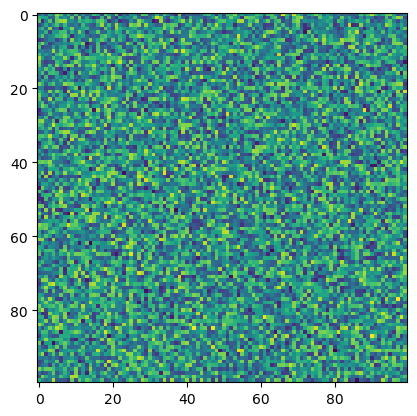

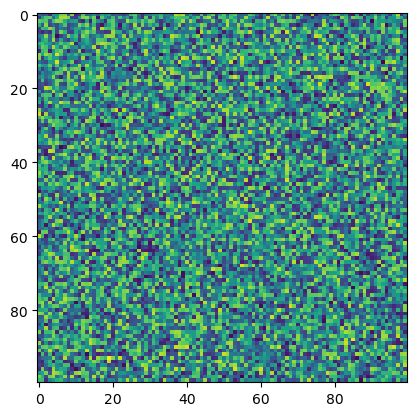

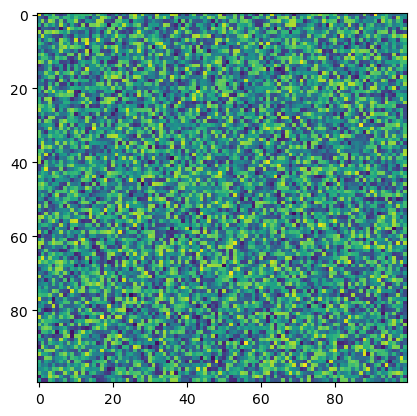

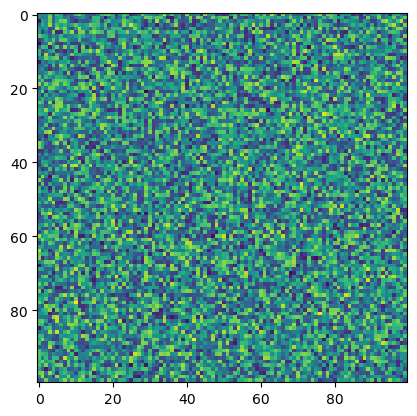

In [50]:
for i in range(4):
    plt.imshow(metastructure_d_1[i, :, :].mean(axis=0).reshape([100, 100]))
    plt.show()